In [42]:
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Concatenate, Masking, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
from sklearn.metrics import roc_curve, auc



### Data Split and Scaling 

In [36]:

# 1) Load saved balanced dataset
with open("../data/note_sequences/balanced_chunks_seq70.pkl", "rb") as f:
    balanced_dataset = pickle.load(f)

# 2) building arrays
X_notes, X_prog, y = [], [], []
for chunk, label in balanced_dataset:
    X_notes.append(chunk[:, [0, 1, 2, 3, 4]])   # dt, interval, pc, (dur or dur_ratio), velocity
    X_prog.append(chunk[:, 5].astype(int))      # program IDs (kept separate for Embedding) we separate it because after scaling an instrument with id = 121 turns into 120 which is meaningless here, so we use an embeddings(treat as a category)
    y.append(label)

X_notes = np.array(X_notes, dtype=np.float32)   # (N, 70, 5)
X_prog  = np.array(X_prog,  dtype=np.int32)     # (N, 70)
y       = np.array(y)

# 3) splitting


Xn_train, Xn_test, Xp_train, Xp_test, y_train, y_test = train_test_split(
    X_notes, X_prog, y, test_size=0.2, random_state=42, stratify=y
)

# 4) Scaler: scale only continuous cols on TRAIN, then apply to TEST
scaler = StandardScaler()
scale_idx = [0, 1, 3, 4]  # dt, interval, (dur or dur_ratio), velocity  -- skip pc at idx 2 because 

ns, nt, nf = Xn_train.shape # remember the 3D shape in our case (10152, 70, 5) ns = number of samples (chunks), nt = timesteps per sample (seq_len=70), nf = features per timestep (5)
Xn_tr_2d = Xn_train.reshape(-1, nf) #flatten (ns, nt, nf) - > (ns*nt, nf) so the scaler can treat each feature column as one long vector. the -1 lets NumPy auto-compute ns*nt
Xn_te_2d = Xn_test.reshape(-1, nf) # do the same flattening for the test set so we can apply the same scaling column-wise

scaler.fit(Xn_tr_2d[:, scale_idx]) # just the columns we want to scale 
Xn_tr_2d[:, scale_idx] = scaler.transform(Xn_tr_2d[:, scale_idx]) #  apply the learned scaling to the TRAIN data in-place
Xn_te_2d[:, scale_idx] = scaler.transform(Xn_te_2d[:, scale_idx]) # apply the SAME scaling to the TEST data ( mean/std)

Xn_train = Xn_tr_2d.reshape(ns, nt, nf) # put train back from 2D (ns*nt, nf) to 3D (ns, nt, nf)
Xn_test  = Xn_te_2d.reshape(Xn_test.shape[0], nt, nf) # do the same 


### Label Encoding
### Model Architecture
### Training Process


In [37]:
# 5) Encode labels

le = LabelEncoder() # create a label encoder to turn string labels like "Bach"/"Mozart" into integers 0,1,..
y_train = le.fit_transform(y_train) # learn the mapping from class names - > integers
y_test  = le.transform(y_test) # convert test labels using the mapping learned from train


# 6) Build model
note_in = Input(shape=(70, 5), name="notes")
prog_in = Input(shape=(70,), dtype="int32", name="programs") # Define the programs (instrument IDs) input: one integer per timestep (0–127)
prog_emb = Embedding(input_dim=128, output_dim=10, mask_zero=False)(prog_in) # Learn a small vector (size 10) for each of the 128 MIDI program IDs (0..127). mask_zero=False because 0 is a *real* instrument, not padding.

# glue the two inputs along the feature axis:
# for example notes:  (batch, 70, 5)   +  program-embedding: (batch, 70, 10)  - >  (batch, 70, 15)
x = Concatenate(axis=-1)([note_in, prog_emb]) 

x = Masking(mask_value=0.0)(x) # after scaling, note features may not be exact zeros, and with origram embedding for ID 0 with mask_zero= Flase this may do nothing, but still safe to keep.

x = Bidirectional(LSTM(128, return_sequences=True))(x) # read the sequence both forward and backward; 128 units each direction

x = Dropout(0.25)(x) # randomly drop 25% of units during training to reduce overfitting. I used to drop 0.3 and 0.2 but 0.25 has the best accuracy in my experiments
x = LSTM(96)(x) # in our experiments, adding this layer could help our model to be improved slitghtly. 
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
out = Dense(len(le.classes_), activation='softmax')(x) # using softmax to return the output as classification

model = Model([note_in, prog_in], out) # Build the Keras model by wiring inputs to output
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # report accuracy during training/validation not one-hot
              metrics=['accuracy']) # report accuracy during training/validation



# 7) Callbacks# Watches
#val_loss each epoch (lower is better). patience=10: 
#if val_loss doesn’t improve for 10 epochs in a row, stop training.
#when it stops, it rolls back the model to the weights from the best
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
ckpt  = ModelCheckpoint('../models/RNN/seq70_checkpoint.keras', monitor='val_loss', save_best_only=True) # if val_loss hits a new best, it saves the model to that path then overwrites the file only when it beats the previous best
rlr   = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# 8) Train
history = model.fit(
    [Xn_train, Xp_train], # inputs: two tensors -> notes (N,70,5) and programs (N,70),
    y_train, # targets: integer class IDs
    validation_data=([Xn_test, Xp_test], y_test), #  run eval on this set each epoch
    epochs=100, # max passes over the training data (EarlyStopping will usually halt before this)
    batch_size=64, # how many sequences per gradient step (trade-off: memory vs. noisy updates)
    callbacks=[early, ckpt, rlr], # What we defined in step 7
    # class_weight=cw,
    verbose=1
)

# 10) Save final model
# model.save("../models/RNN/balanced_chunks_seq70.keras")


Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.3814 - loss: 1.3007 - val_accuracy: 0.4924 - val_loss: 1.1229 - learning_rate: 0.0010
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5162 - loss: 1.0791 - val_accuracy: 0.5598 - val_loss: 0.9444 - learning_rate: 0.0010
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.5634 - loss: 0.9583 - val_accuracy: 0.6125 - val_loss: 0.8806 - learning_rate: 0.0010
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5971 - loss: 0.9244 - val_accuracy: 0.6322 - val_loss: 0.8096 - learning_rate: 0.0010
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.6147 - loss: 0.8707 - val_accuracy: 0.6465 - val_loss: 0.7855 - learning_rate: 0.0010
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6616 - loss: 0.7900 - val_accuracy: 0.6391 - val_loss: 0.7923 - learning_rate: 0.0010
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.6515 -

### Evaluation the best saved LSTM model

In [39]:
model = tf.keras.models.load_model("../models/RNN/balanced_chunks_seq70.keras")
model.summary()  # quick sanity

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ programs            │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ notes (InputLayer)  │ (None, 70, 5)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 70, 10)    │      1,280 │ programs[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 70, 15)    │          0 │ notes[0][0],      │
│ (Concatenate)       │                   │            │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 70, 15)    │          0 │ concatenate_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_4 (Masking) │ (None, 70, 15)    │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_15 (Any)        │ (None, 70)        │          0 │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 70, 256)   │    147,456 │ masking_4[0][0],  │
│ (Bidirectional)     │                   │            │ any_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 70, 256)   │          0 │ bidirectional_4[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 96)        │    135,552 │ dropout_12[0][0], │
│                     │                   │            │ any_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 96)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      6,208 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │        260 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 872,270 (3.33 MB)

 Trainable params: 290,756 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 581,514 (2.22 MB)

### Model evaluation and confusion matrix

Test Accuracy: 0.8464
Test Loss: 0.4486
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Classification Report:
              precision    recall  f1-score   support

        Bach       0.94      0.95      0.95       508
   Beethoven       0.75      0.75      0.75       507
      Chopin       0.87      0.90      0.89       508
      Mozart       0.82      0.78      0.80       508

    accuracy                           0.85      2031
   macro avg       0.85      0.85      0.85      2031
weighted avg       0.85      0.85      0.85      2031



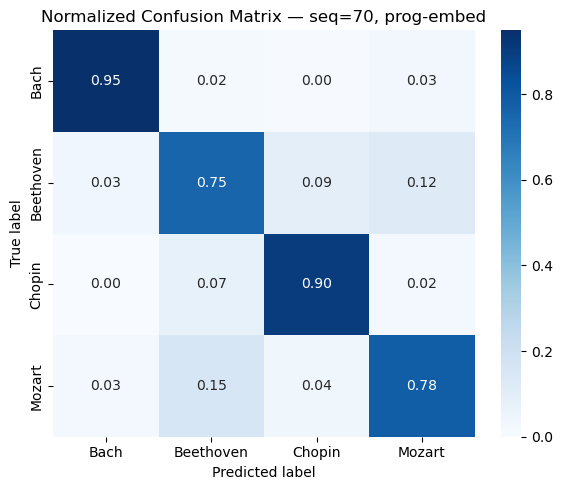

In [ ]:
# Evaluate & Plot Confusion Matrix

# Evaluate
loss, acc = model.evaluate([Xn_test, Xp_test], y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predictions
y_pred_probs = model.predict([Xn_test, Xp_test])
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Normalized Confusion Matrix — seq=70, prog-embed")
plt.tight_layout()
plt.show()


### ROC/AUC evaluation (one-vs-rest)

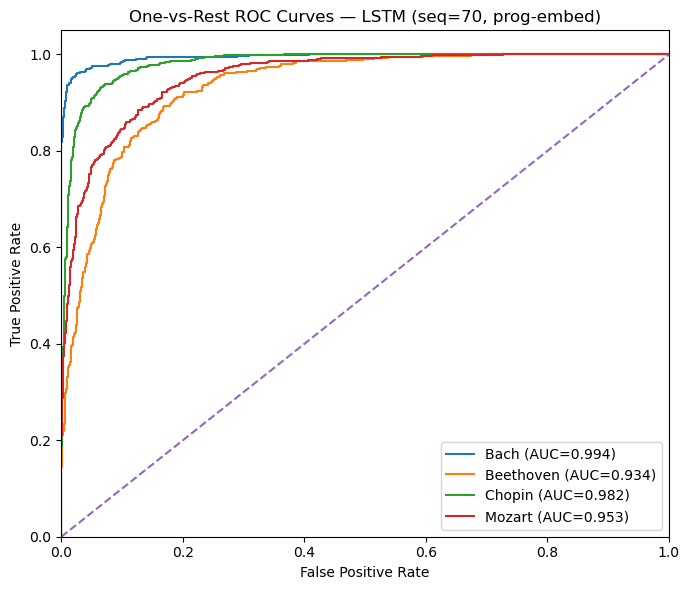

In [44]:


# 1) Ensure y_test are integer class IDs (same encoder used in training)
# If they’re strings, do: y_test_enc = le.transform(y_test)
y_test_enc = y_test

# 2) Binarize to one-vs-rest (shape: [n_samples, n_classes])
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test_enc, classes=np.arange(n_classes))

# 3) Get predicted probabilities from the saved model
y_pred_probs = model.predict([Xn_test.astype("float32"), Xp_test.astype("int32")], verbose=0)

# 4) Plot per-class ROC
plt.figure(figsize=(7,6))
for i, cls in enumerate(le.classes_):
    # skip if this class is missing in y_test (rare, but safe)
    if len(np.unique(y_test_bin[:, i])) < 2:
        print(f"Skipping ROC for class '{cls}' (not enough positives/negatives).")
        continue

    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")

# chance line + cosmetics
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves — LSTM (seq=70, prog-embed)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
